# Just Reminder(This is not my code)

I have used the open source code from " https://www.kaggle.com/competitions/dm2021-lab2-hw2 " and I apply parameter efficent fine tuning(PEFT) approach on  Twitter Emotion Dataset. But we need to apply some data preprocessing techniques on the dataset for performance improvments the f1-score is 0.47 after fine tuning by PEFT approache LORA.


**What is LORA?**\
LoRA (Low rank Adaption of LLM) LoRA is one of the widely used PEFT method. Even in most cases when someone says PEFT, they typically mean LoRA only. In the LoRA, we kept original weights of model frozen and inject the small new trainable parameters with low dimensions matrices. You can understand it from the following image.

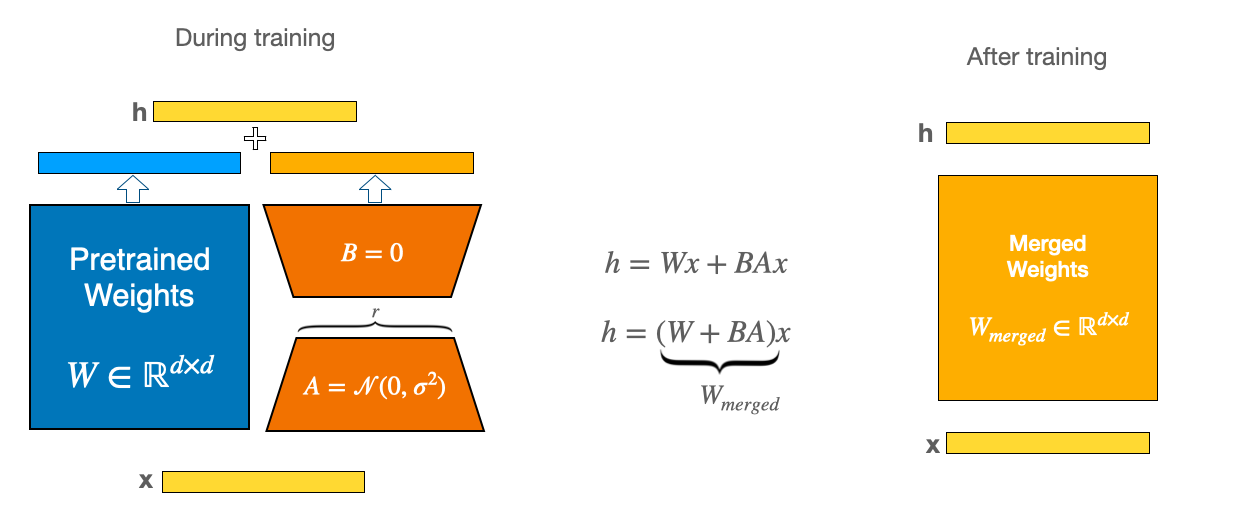

In [ ]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import random
import pandas as pd
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer,AutoModelForSequenceClassification,AdamW
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_identification = pd.read_csv("/content/gdrive/My Drive/Homework/data_identification.csv")
emotion = pd.read_csv('/content/gdrive/My Drive/Homework/emotion.csv')
sampleSubmission = pd.read_csv("/content/gdrive/My Drive/Homework/sampleSubmission.csv")

tweets = []
for line in open('/content/gdrive/My Drive/Homework/tweets_DM.json', 'r'):
    tweets.append(json.loads(line))

dicts={}
for i in range(len(tweets)):
    dicts[tweets[i]['_source']['tweet']['tweet_id']]=tweets[i]['_source']['tweet']['text']

sent_train=[]
for i in range(len(emotion.tweet_id)):
    sent_train.append(dicts[emotion.tweet_id[i]])

emotion['sentence']=sent_train
training=emotion

d = {'id': training.tweet_id, 'sentence': training.sentence, 'emotion': training.emotion}
train = pd.DataFrame(data=d)

test_id=sampleSubmission['id']

sent_test=[]
for i in range(len(sampleSubmission.id)):
    sent_test.append(dicts[sampleSubmission.id[i]])

sampleSubmission['sentence']=sent_test
test=sampleSubmission

d = {'id': test.id, 'sentence': test.sentence}
test = pd.DataFrame(data=d)

train.to_csv('train_data.csv', index=False)
test.to_csv('test_data.csv', index=False)

In [ ]:
train_balanced = train

In [ ]:
train_data=train_balanced

test_data=test

y_train1=train_data.emotion.values

df1 = train_data.groupby(['emotion']).count()['sentence']

index=df1.index

y_train_conv=[]

for i in y_train1:
    for j in range(8):
        if i==index[j]:
            y_train_conv.append(j)

y_train=np.array(y_train_conv)

In [ ]:
text=train_data.sentence.values
text_tests=test_data.sentence.values

In [ ]:
labels=y_train
labels

array([5, 2, 1, ..., 3, 4, 1])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-emotion',do_lower_case = True)

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids_tests = []
attention_mask_tests = []
for i in text_tests:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids_tests.append(encoded_data['input_ids'])
    attention_mask_tests.append(encoded_data['attention_mask'])
input_ids_tests = torch.cat(input_ids_tests,dim=0)
attention_mask_tests = torch.cat(attention_mask_tests,dim=0)

In [ ]:
dataset = TensorDataset(input_ids,attention_mask,labels)
train_size = int(0.78*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  1135339
Validation Size -  320224


In [ ]:
dataset_test = TensorDataset(input_ids_tests,attention_mask_tests)
print(len(dataset_test))
train_test = DataLoader(dataset_test, shuffle=True,batch_size = 256)

411972


In [ ]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 256)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 256)

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=16, lora_alpha=32, lora_dropout=0.2
)

In [ ]:
model_orginal = AutoModelForSequenceClassification.from_pretrained(
'cardiffnlp/twitter-roberta-base-sentiment',
num_labels = 8,
ignore_mismatched_sizes=True,
output_attentions = False,
output_hidden_states = False)
model_peft = get_peft_model(model_orginal, peft_config)
model_peft.print_trainable_parameters()

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 891,656 || all params: 125,543,440 || trainable%: 0.710237030306004


In [ ]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_peft.to(device)

print(device)

cuda


In [ ]:
optimizer = AdamW(model_peft.parameters(),lr = 1e-5,eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [ ]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [ ]:
def evaluate(dataloader_test, class_weights=None):
    model_peft.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }

        with torch.no_grad():
            outputs = model_peft(**inputs)

        loss = outputs[0]
        logits = outputs[1]

        if class_weights is not None:
            weight = torch.tensor(class_weights, device=device)
            loss = torch.nn.functional.cross_entropy(logits, inputs['labels'], weight=weight)

        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):

    model_peft.train()

    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model_peft.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model_peft(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model_peft.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(train_dl)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/4435 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.3913844046759363
Validation loss: 1.2751496435641099
Accuracy: 0.5358217997401818


Epoch 2:   0%|          | 0/4435 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.2764453083444744
Validation loss: 1.2099507812211077
Accuracy: 0.5628029129609273


Epoch 3:   0%|          | 0/4435 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.2374621443979634
Validation loss: 1.1816953607409788
Accuracy: 0.5741574647746578


Epoch 4:   0%|          | 0/4435 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.222746163290813
Validation loss: 1.1742704700318267
Accuracy: 0.5773770860397721


In [ ]:
output_dir = './'
model_peft_to_save = model_peft.module if hasattr(model_peft, 'module') else model_peft
model_peft_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.json',
 './merges.txt',
 './added_tokens.json',
 './tokenizer.json')

In [ ]:
from transformers import AutoTokenizer,AutoModelForSequenceClassification
import torch
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model_peft_loaded = AutoModelForSequenceClassification.from_pretrained(output_dir, num_labels=8, ignore_mismatched_sizes=True)

Loading BERT tokenizer...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def Sentiment(sent):
    output_dir = './'
    tokenizer = AutoTokenizer.from_pretrained(output_dir)
    model_peft_loaded = AutoModelForSequenceClassification.from_pretrained(output_dir, num_labels=8, ignore_mismatched_sizes=True)
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )

    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_peft_loaded = model_peft_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_peft_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [ ]:
Sentiment('I am happy.')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenizati

tensor(4, device='cuda:0')

In [ ]:
model_peft.eval()
logit = []
summs=0
lens=len(dataset_test)/16
for batch in train_test:
    batchs = tuple(b.to(device) for b in batch)

    inputs = {'input_ids':      batchs[0],
              'attention_mask': batchs[1]
             }

    outputs = model_peft(**inputs)
    # print(outputs)
    logit += torch.argmax(outputs[0], dim=1).cpu()
    # out.append(logit.item())
    if summs%1000==0:
        print(summs/lens)
    summs+=1

0.0
0.03883759090423621


In [ ]:
logit

[tensor(2),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(7),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(1),
 tensor(4),
 tensor(2),
 tensor(5),
 tensor(4),
 tensor(4),
 tensor(7),
 tensor(4),
 tensor(2),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(4),
 tensor(3),
 tensor(4),
 tensor(1),
 tensor(4),
 tensor(3),
 tensor(4),
 tensor(0),
 tensor(1),
 tensor(7),
 tensor(5),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(2),
 tensor(3),
 tensor(4),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(7),
 tensor(5),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(4),
 tensor(4),
 tensor(2),
 tensor(4),
 tensor(7),
 tensor(2),
 tensor(4),
 tensor(4),
 tensor(4),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(5),
 tensor(5),
 tensor(7),
 tensor(7),
 tensor(4),
 tensor(4),
 tensor(4),
 ten

In [ ]:
pred=[]
for i in logit:
    pred.append(df1.index.values[i])

In [ ]:
test_data['emotion']=pred

In [ ]:
sb=test_data.loc[:,['id','emotion']]
sb

,id,emotion
0,0x2c7743,disgust
1,0x2c1eed,joy
2,0x2826ea,sadness
3,0x356d9a,sadness
4,0x20fd95,joy
...,...,...
411967,0x351857,joy
411968,0x2c028e,joy
411969,0x1f2430,sadness
411970,0x2be24e,sadness


In [ ]:
sb.to_csv('/content/gdrive/My Drive/Homework/finetunedberttwo.csv', index=False)